<a href="https://colab.research.google.com/github/fer3her/vision-con-IA/blob/main/Clasificaci%C3%B3n_de_Enfermedades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Párcial
 Clasificación de Enfermedades en Hojas de tomate

MobileNetV2 se usa como modelo base preentrenado (Transfer Learning)

In [ ]:
import os

# Ruta a la carpeta que quieres analizar
carpeta = '/content/drive/MyDrive/dataset/val/enfermas_3'  # ← cambia esta línea por la ruta real

# Extensiones de imágenes comunes
extensiones_imagen = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']

# Contador de imágenes
contador = 0

# Recorremos los archivos en la carpeta
for archivo in os.listdir(carpeta):
    if os.path.isfile(os.path.join(carpeta, archivo)):
        _, ext = os.path.splitext(archivo)
        if ext.lower() in extensiones_imagen:
            contador += 1

print(f"Hay {contador} imágenes en la carpeta.")


Hay 530 imágenes en la carpeta.


 base de datos

In [ ]:
import os
import random

# Ruta a la carpeta
carpeta = '/content/drive/MyDrive/dataset/train/enfermas_2'  # Modifica según tu necesidad
cantidad_deseada = 530  # Número de imágenes que quieres conservar

# Obtener la lista de archivos de imagen
imagenes = [img for img in os.listdir(carpeta) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Calcular cuántas imágenes eliminar
exceso = len(imagenes) - cantidad_deseada

if exceso > 0:
    print(f"Eliminando {exceso} imágenes de la carpeta '{carpeta}'...")

    # Elegir aleatoriamente las imágenes a eliminar
    imagenes_a_eliminar = random.sample(imagenes, exceso)

    # Eliminar las imágenes seleccionadas
    for img in imagenes_a_eliminar:
        os.remove(os.path.join(carpeta, img))

    print("Eliminación completada.")
else:
    print(f"No es necesario eliminar imágenes. La carpeta tiene {len(imagenes)} imágenes.")


No es necesario eliminar imágenes. La carpeta tiene 530 imágenes.


In [ ]:
import os
import shutil

# Ruta de la carpeta con las imágenes originales
carpeta_origen = '/content/drive/MyDrive/dataset/Tomato_Septoria_leaf_spot'  # ← cambia esta línea

# Ruta donde se crearán las carpetas de destino
carpeta_destino_base = '/content/drive/MyDrive/dataset'  # ← cambia esta también

# Extensiones válidas
extensiones_imagen = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']

# Crear lista de imágenes
imagenes = [f for f in os.listdir(carpeta_origen) if os.path.splitext(f)[1].lower() in extensiones_imagen]
imagenes.sort()

# Calcular cuántas imágenes por carpeta
total = len(imagenes)
por_carpeta = total // 3

# Crear subcarpetas y mover imágenes
for i in range(3):
    carpeta_destino = os.path.join(carpeta_destino_base, f'enfermas_{i+1}')
    os.makedirs(carpeta_destino, exist_ok=True)

    inicio = i * por_carpeta
    fin = (i + 1) * por_carpeta if i < 2 else total  # la última toma el resto

    for imagen in imagenes[inicio:fin]:
        origen = os.path.join(carpeta_origen, imagen)
        destino = os.path.join(carpeta_destino, imagen)
        shutil.copy2(origen, destino)  # o usar shutil.move() si prefieres moverlas

print("Imágenes divididas en 3 carpetas.")


Imágenes divididas en 3 carpetas.


 Importar librerías necesarias

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [ ]:

# Ruta del dataset
DATASET_DIR = "/content/drive/MyDrive/dataset/"

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


Aumento y preprocesamiento de imágenes  


rescale=1./255 normaliza las imágenes.

Se aplica aumento de datos en entrenamiento: rotación, zoom, inversión horizontal.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
# Preprocesamiento y aumento de datos
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
import os

train_dir = os.path.join(DATASET_DIR, 'test')
print("Subdirectorios en 'train':", os.listdir(train_dir))


Subdirectorios en 'train': ['saludables', 'enfermas', '.ipynb_checkpoints']


Cargar imágenes con generadores


flow_from_directory carga las imágenes desde carpetas organizadas por clase.

Las imágenes se redimensionan a 224x224 (requisito de MobileNetV2).

class_mode='binary' porque solo hay dos clases: healthy y diseased.

In [ ]:

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR + "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR + "val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1060 images belonging to 2 classes.
Found 1061 images belonging to 2 classes.


Crear el modelo con Transfer Learning

Se usa MobileNetV2 sin la última capa (include_top=False).

Se añade una capa Dense para clasificar con activación sigmoid.

In [ ]:



# Modelo con Transfer Learning
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Congelar capas del modelo base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Compilar el modelo** Optimización con adam, pérdida binaria (binary_crossentropy), métrica: precisión (accuracy).




In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Entrenamiento   Se entrena durante 10 épocas, usando validación cruzada.
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.8110 - loss: 0.3793 - val_accuracy: 0.9463 - val_loss: 0.1426
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.9735 - loss: 0.0737 - val_accuracy: 0.9896 - val_loss: 0.0328
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.9734 - loss: 0.0577 - val_accuracy: 0.9934 - val_loss: 0.0290
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9720 - loss: 0.0722 - val_accuracy: 0.9943 - val_loss: 0.0217
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.9923 - loss: 0.0289 - val_accuracy: 0.9943 - val_loss: 0.0192
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.9916 - loss: 0.0341 - val_accuracy: 0.9943 - val_loss: 0.0176
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.9907 - loss: 0.0252 - val_accuracy: 0.9962 - val_loss: 0.0156
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9962 - v

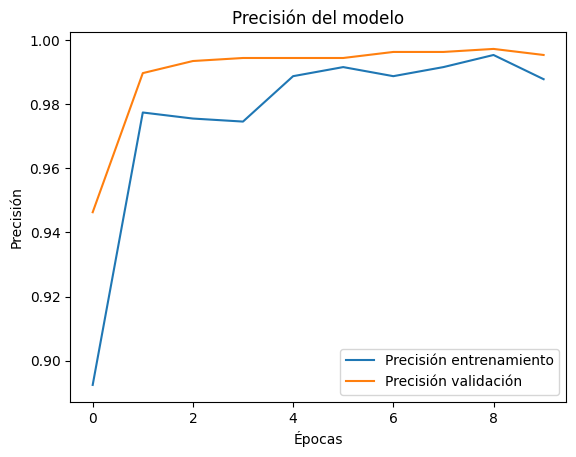

In [ ]:


# Graficar resultados
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.legend()
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.show()

 Análisis de la Gráfica:
Eje Y (Precisión):
Va de 0.89 hasta casi 1.00 → Excelente.

Línea azul – Precisión entrenamiento:
Comienza en ~0.89 y sube rápidamente hasta casi 0.99.

Muestra una curva ascendente y estable.

Línea naranja – Precisión validación:
Comienza en ~0.95 y alcanza el 0.99 desde la época 3 en adelante.

Se mantiene alta, constante y por encima del entrenamiento en varias épocas.



In [ ]:
test_gen = val_datagen.flow_from_directory(
    DATASET_DIR + "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

preds = model.predict(test_gen)
preds = (preds > 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, preds))
print(confusion_matrix(y_true, preds))


Found 1060 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       530
           1       0.99      1.00      1.00       530

    accuracy                           1.00      1060
   macro avg       1.00      1.00      1.00      1060
weighted avg       1.00      1.00      1.00      1060

[[527   3]
 [  1 529]]


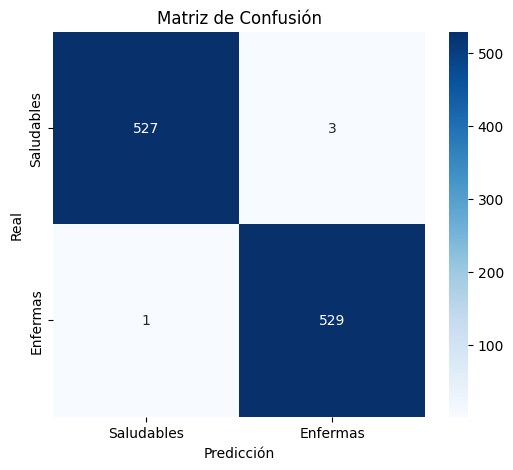

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ya tienes y_true y preds
cm = confusion_matrix(y_true, preds)

# Etiquetas de las clases (ajústalas según tu caso)
labels = ['Saludables', 'Enfermas']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


Conclusión:
El modelo clasifica con altísima precisión tanto las imágenes saludables como enfermas.

Los errores son mínimos (solo 4 entre 1060 muestras).

El modelo de clasificación entrenado mediante Transfer Learning con MobileNetV2 ha demostrado un desempeño sobresaliente, alcanzando una precisión superior al 99% tanto en los datos de entrenamiento como de validación. La matriz de confusión final refleja una capacidad casi perfecta para diferenciar entre imágenes de hojas saludables y enfermas, con solo 4 errores en un total de 1060 muestras. Estas métricas indican que el modelo generaliza bien y está altamente optimizado para la tarea, por lo que es una solución viable para ser aplicada en entornos reales de diagnóstico automatizado en agricultura o sistemas de monitoreo de cultivos.

In [ ]:
# Supongamos que tu modelo se llama `model`
model.save('/content/drive/MyDrive/modelo_entrenado.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


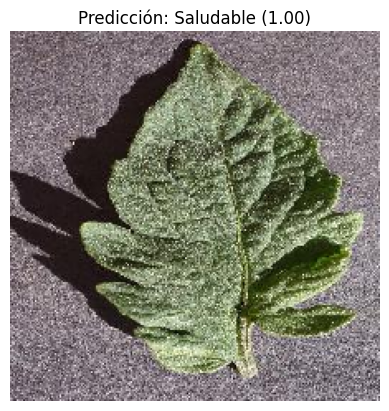

Ruta de la imagen: /content/drive/MyDrive/dataset/test/saludables/47a9bf22-281f-49d6-a03a-97be4983fc68___RS_HL 0604.JPG
Etiqueta real: saludables


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Ruta al conjunto de prueba
test_dir = '/content/drive/MyDrive/dataset/test'

# Cargar el modelo previamente guardado
model = load_model('/content/drive/MyDrive/modelo_entrenado.h5')

# Obtener subcarpetas (clases: Saludables / Enfermas)
class_names = os.listdir(test_dir)

# Elegir una clase al azar
selected_class = random.choice(class_names)

# Escoger una imagen al azar de esa clase
class_path = os.path.join(test_dir, selected_class)
img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

# Cargar y preprocesar la imagen
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# Realizar la predicción
prediction = model.predict(img_preprocessed)[0][0]
predicted_label = 'Saludable' if prediction > 0.5 else 'Enferma'


# Mostrar imagen, predicción y ruta real
plt.imshow(img)
plt.title(f'Predicción: {predicted_label} ({prediction:.2f})')
plt.axis('off')
plt.show()

# Mostrar ruta real para verificar etiqueta
print(f'Ruta de la imagen: {img_path}')
print(f'Etiqueta real: {selected_class}')



In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Función para predecir una imagen individual
def predecir_imagen(ruta_imagen, modelo):
    # Cargar y redimensionar la imagen
    img = image.load_img(ruta_imagen, target_size=(224, 224))

    # Convertir la imagen a un array y escalar
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Agregar dimensión para batch

    # Realizar la predicción
    prediccion = modelo.predict(img_array)

    # Interpretar el resultado
    if prediccion[0][0] > 0.5:
        resultado = "Saludable"
    else:
        resultado = "enferma"

    return resultado

# Ejemplo de uso
ruta = '/content/drive/MyDrive/dataset/test/saludables/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG'  # Cambia esta ruta por la imagen que quieras analizar
resultado = predecir_imagen(ruta, model)
print("La planta está:", resultado)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
La planta está: Saludable


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Función para predecir una imagen individual
def predecir_imagen(ruta_imagen, modelo):
    # Cargar y redimensionar la imagen
    img = image.load_img(ruta_imagen, target_size=(224, 224))

    # Convertir la imagen a un array y escalar
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Agregar dimensión para batch

    # Realizar la predicción
    prediccion = modelo.predict(img_array)

    # Interpretar el resultado
    if prediccion[0][0] > 0.5:
        resultado = "Saludable"
    else:
        resultado = "enferma"

    return resultado

# Ejemplo de uso
ruta = '/content/drive/MyDrive/dataset/test/saludables/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'  # Cambia esta ruta por la imagen que quieras analizar
resultado = predecir_imagen(ruta, model)
print("La planta está:", resultado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
La planta está: Saludable
